# Twitter Text Classification

In this post, we consider the problem of classifying tweets to a set of categories. In particular, our goal is to build a model that classifies tweets to different categories such as technology, politics, weather, health, etc. 
Given the large number of tweets tweeted each day or even each hour, tweet classification can be very useful when our goal is to filter noise and extract useful and relevant information from tweets. For example, in election season, we can filter for tweets that fall in politics category before doing a sentiment analysis on tweets to find which candidates are favored by the population. As another example, we can extract technology related tweets to find out what is trending in the technology domain. Later in this post, we will obtain tweets that fall in weather category to find out in which parts of the country people are talking about the weather. 


The two broad approaches that can be used for this problem are supervised and unsupervised learning. In this post we focus on supervised learning. The unsupervised approach focuses on text clustering and topic modeling and we will explore that later in a separate post.

Successful application of supervised learning would require a large enough dataset of labeled tweets. One approach is to label the tweets manually, but that will turn out to be a time-consuming and painstaking task. Instead, the approach we use here is to collect tweets from well-established Twitter accounts such as those of news agencies that focus on a particular topic, e.g., politics, technology, or weather. The drawback of this method is that inevitably, there will be tweets that are mislabeled. For example, a twitter account that tweets about technology may occasionally tweets material about health or politics as well and this could interfere with our classification and decrease the classification accuracy. We pursue this approach here and later on perform a performance evaluation to find out if this approach is practical.

## Collecting Tweets

To collect tweets, in addition to a Twitter account, we need to create an [Twitter app](http://apps.twitter.com)
associated with the account. Once we register the app, we obtain the credentials necessary to authorize our application to access Twitter data as if it was the Twitter account itself. Once we have the credentials, we can use python tweepy library to access our Twitter account data. The following code sets up tweepy API assuming the app credentials are in 'credentials.csv'.

In [1]:
import pandas as pd 
credentials = pd.read_csv('credentials.csv')
consumer_key = credentials['consumer_key'][0]
consumer_secret = credentials['consumer_secret'][0]
access_token = credentials['access_token'][0]
access_secret = credentials['access_secret'][0]
 
import tweepy
from tweepy import OAuthHandler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True)

import warnings
warnings.simplefilter('ignore')

As mentioned before, we are going to follow some well-known Twitter accounts to prepare our labeled data. Here are the account we have chosen to follow:

In [2]:
users = api.friends('<twitter account>', count=100)
[u.screen_name for u in users]

[u'NYTSports',
 u'nytimestech',
 u'BBCPolitics',
 u'BBCSport',
 u'cnnsport',
 u'politico',
 u'CNNPolitics',
 u'HarvardHealth',
 u'NYTHealth',
 u'cnnhealth',
 u'cnntech',
 u'CNET',
 u'rtetwip',
 u'PnPCBC',
 u'NewshubPolitics',
 u'SkyNewsPolitics',
 u'CBSPolitics',
 u'RealClearNews',
 u'foxnewspolitics',
 u'ABCPolitics',
 u'CBCHealth',
 u'CBSHealth',
 u'KHNews',
 u'NBCNewsHealth',
 u'NPRHealth',
 u'bbchealth',
 u'EverydayHealth',
 u'HealthHive',
 u'breakingbytes',
 u'FoxNewsTech',
 u'ReutersTech',
 u'BBCTech',
 u'technology',
 u'TechCrunch',
 u'fttechnews',
 u'NBCNewsTech',
 u'ForbesTech',
 u'TheWeatherNetUS',
 u'bn9weather',
 u'SkyNewsWeather',
 u'HTSportsNews',
 u'NewsdaySports',
 u'FOXSportsNews',
 u'SkySportsNews',
 u'AM730Traffic']

As we can see, we are following 45 account that tweet about technology, politics, health, weather, traffic, and sport. Next we set up a timer to periodically collect new tweets from these accounts and save them to a MongoDB database. MongoDB provides data persistence and provides an easy way to manage Twitter data. In addition, it accepts json data which is very convenient, since we get the tweets from Twitter API as json.

In [3]:
import threading
import time
from pymongo import MongoClient

def collect_tweets(users):
    curr_count = news_tweets.count()
    now = time.time()
    print("Started collecting tweets")
    for user in users:
        try:
            tweets = tweepy.Cursor(api.user_timeline,screen_name=user.screen_name).items()
        except:
            continue
            
        for tw in tweets:
            # See if the tweet already exists in the database
            if news_tweets.find_one({'id':tw.id}):
                break

            try:
                news_tweets.insert_one(tw._json)
            except DuplicateKeyError:
                break
                
    new_count = news_tweets.count()
    new_time = time.time() - now
    print("Collected %d tweets in %.2f seconds" % (new_count - curr_count, new_time))

    

class TimerThread(threading.Thread):
    def __init__(self, interval, task, args=[], kwargs={}):
        super(TimerThread, self).__init__()
        self.stop_ = False
        self.interval = interval
        self.args = args
        self.kwargs = kwargs
        self.task = task
        self.start()
        
    def run(self):
        while not self.stop_:
            self.task(*self.args, **self.kwargs)
            time.sleep(self.interval)
            
    def stop(self):
        self.stop_ = True
client = MongoClient()
news_tweets = client.tweets_db.new_tweets

tthread = TimerThread(15 * 60, collect_tweets, [users])

Started collecting tweets


In [4]:
tthread.stop()

In the above code:
* We set up a timer thread to wake up every 15 minutes. Once the thread wakes up it goes though the followed accounts and downloads the tweets that are posted since the last thread invocation.

* For each new tweet, we check the database to see we have already collected this tweet. To do this we use the 'id' field which is unique for each tweet.

* Once we see a duplicate tweets for an account, it means we have collected all new tweets generated by this account in the past 15 minutes. So we move on to the next account.

After running the code for a few hours, we have collected around 140000 tweets:

In [1]:
from pymongo import MongoClient

client = MongoClient()
news_tweets = client.tweets_db.new_tweets
news_tweets.count()

140077

We store the relevant information from tweets in a data-frame and save it as a pickle file as well.

In [7]:
import pandas as pd
tweets_df = pd.DataFrame([[tw['id'], tw['text'], tw['user']['screen_name']] 
                           for tw in news_tweets.find()], columns=['id', 'text', 'user'])
tweets_df.to_pickle('data/tweets_df.pkl')

tweets_df.head()

,id,text,user
0,1013481218631962626,"She's 89, deaf and suffering from dementia. Is...",CBCHealth
1,1013150428643647490,"OHIP+ no longer covers kids, young adults with...",CBCHealth
2,1012972838339465216,"Time's up for sexual harassment in medicine, s...",CBCHealth
3,1012820018327900160,Health ministers meeting in Winnipeg want nati...,CBCHealth
4,1012807568358600704,Amazon buys its 1st online pharmacy https://t....,CBCHealth


The following peace of code assigns Twitter accounts that generate the tweets to Health, Politics, Sports, Tech, Traffic, and Weather categories based on the account username.

In [3]:
import numpy as np

users_df = pd.DataFrame(np.unique(tweets_df.user).tolist(), columns=['user'])

cats = [('Traffic', None),
        ('Tech', ['tech', 'breakingbytes', 'CNET']),
        ('Health', ['health', 'KHNews']),
        ('Sports', 'sport'),
        ('Weather', None),
        ('Politics', ['politic', 'rtetwip', 'realclear', 'PnPCBC']),
       ]
for cat in cats:
    keywords = cat[1]
    cat_name = cat[0]
    if keywords is None:
        keywords = cat_name
    if not isinstance(keywords, list):
        keywords = [keywords]
    print cat
    for index, u in zip(users_df.index, users_df.user):
        for kw in keywords:
            if u.lower().find(kw.lower()) != -1:
                print("\t%s %s"% (u, kw))
                users_df.loc[index, 'cat'] = cat_name
                break

('Traffic', None)
	AM730Traffic Traffic
('Tech', ['tech', 'breakingbytes', 'CNET'])
	BBCTech tech
	CNET CNET
	ForbesTech tech
	FoxNewsTech tech
	NBCNewsTech tech
	ReutersTech tech
	TechCrunch tech
	breakingbytes breakingbytes
	cnntech tech
	fttechnews tech
	nytimestech tech
	technology tech
('Health', ['health', 'KHNews'])
	CBCHealth health
	CBSHealth health
	EverydayHealth health
	HarvardHealth health
	HealthHive health
	KHNews KHNews
	NBCNewsHealth health
	NPRHealth health
	NYTHealth health
	bbchealth health
	cnnhealth health
('Sports', 'sport')
	BBCSport sport
	FOXSportsNews sport
	HTSportsNews sport
	NYTSports sport
	NewsdaySports sport
	SkySportsNews sport
	cnnsport sport
('Weather', None)
	SkyNewsWeather Weather
	TheWeatherNetUS Weather
	bn9weather Weather
('Politics', ['politic', 'rtetwip', 'realclear', 'PnPCBC'])
	ABCPolitics politic
	BBCPolitics politic
	CBSPolitics politic
	CNNPolitics politic
	NewshubPolitics politic
	PnPCBC PnPCBC
	RealClearNews realclear
	SkyNewsPolitics p

We can now add a new columns to the tweet data-frame that indicates each tweet's category:

In [ ]:
users_df.set_index('user', inplace=True)
tweets_df['cat'] = tweets_df['user'].map(users_df['cat'])

To prepare the category data for classification we need to translate categories to labels using a label-encoder: 

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

tweets_df['cat_encoded'] = label_encoder.fit_transform(tweets_df.cat)

Here is the resulting data-frame after shuffling the rows:

In [4]:
tweets_df = tweets_df.sample(frac=1)
tweets_df.reset_index(inplace=True, drop=True)
tweets_df.head()

,id,text,user,cat,cat_encoded
0,1002637424906915846,President Trump's tariff fight could hurt the ...,CNNPolitics,Politics,1
1,1009077135925968896,"Against the Nationals, the fell to a 5-3 defea...",NYTSports,Sports,2
2,976666096530087941,India is examining how to build habitations on...,technology,Tech,3
3,935934092876701696,"RT @RealClearPR: ""With near full employment in...",RealClearNews,Politics,1
4,1005142973707837440,Will support Brazil but also looking forward t...,HTSportsNews,Sports,2


Let's have a look at the number of tweets we have collected from each category.

In [12]:
tweets_df['cat'].value_counts()

Heath       35640
Tech        33161
Politics    31675
Sports      23173
Weather      9740
Traffic      3331
Name: cat, dtype: int64

We observe that some categories like Weather and Traffic contain fewer tweets since the corresponding tweeter account generated the tweets at a slower pace. However, this is not problematic since all categories contain a reasonable number of tweets for the classification task to be meaningful.

## Text Preprocessing and Feature Extraction

Next, we develop a transformer that performs some cleaning and preprocessing of tweet texts. For more details about this transformer please see the article [Insults Detection in Social Media](http://amirnasri.github.io/insults-kaggle.html).

In [13]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        comments_clean = []
        for c in X:
            c = c.replace('\\\\', '\\')
            c = c.replace('\\n', ' ')
            c = re.sub(r'[-_"]', '', c)
            c = re.sub(r'[*%&,?!;]', ' ', c)
            c = re.sub(r"(.)\1{2,}", '\g<1>', c)
            c = re.sub(r'\.(\s+|$)', ' ', c)
            c = re.sub(r'[^\x00-\x7F]+',' ', c)
            c = re.sub(r'https?://[\w./]+', ' ', c)
            c = [wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(w, pos='v')).lower() 
                          for w in c.split()]
            c = " ".join(w for w in c if len(w) > 2)
            comments_clean.append(c)
        return comments_clean

prep = Preprocessor()

tweets_df['text_processed'] = prep.fit_transform(tweets_df['text'])

tweets_df.head()

,id,text,user,cat,cat_encoded,text_processed
0,1002637424906915846,President Trump's tariff fight could hurt the ...,CNNPolitics,Politics,1,president trump's tariff fight could hurt the ...
1,1009077135925968896,"Against the Nationals, the fell to a 5-3 defea...",NYTSports,Sports,2,against the nationals the fell defeat more tha...
2,976666096530087941,India is examining how to build habitations on...,technology,Tech,3,india examine how build habitation the moon
3,935934092876701696,"RT @RealClearPR: ""With near full employment in...",RealClearNews,Politics,1,@realclearpr: with near full employment indian...
4,1005142973707837440,Will support Brazil but also looking forward t...,HTSportsNews,Sports,2,will support brazil but also look forward #lio...


Using the processed text we can extract useful text features by performing text vectorization. Again, for a more detailed explanation please refer to [Insults Detection in Social Media](http://amirnasri.github.io/insults-kaggle.html).

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from scipy.sparse import hstack

tfidf_word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_char_vectorizer = TfidfVectorizer(ngram_range=(1, 7), analyzer='char', max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_word = tfidf_word_vectorizer.fit_transform(tweets_df['text_processed'])
tfidf_char = tfidf_char_vectorizer.fit_transform(tweets_df['text_processed'])

tfidf_word_char = hstack([tfidf_word, tfidf_char]).tocsr()


Now our tweet data is ready for the classification task. In particular, the we have the input data 'X' in 'tfidf_word_char' while are target variables 'y' are given by tweets_df['cat_encoded'].

## Text Classification

We first divide our data into cv and test sets. We use the cv set to train the classifier using k-fold cross-validation. We then examine the performance of the resulting classifier on the test set.

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)

cv_index, test_index = sss.split(tfidf_word_char, tweets_df['cat_encoded']).next()

X_cv, y_cv = tfidf_word_char[cv_index], tweets_df['cat_encoded'][cv_index]
X_test, y_test = tfidf_word_char[test_index], tweets_df['cat_encoded'][test_index]

For classifier, we use Logisitic-Regression classifier since it is an efficient classifier that achieves great results on text classification tasks.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

Using this classifier, we perform a grid-search on the cv set to obtain the best regularization parameter C:

In [33]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(lr, param_grid={'C': np.logspace(-1, 3, 5)}, return_train_score=True, n_jobs=3)
gs.fit(X_cv, y_cv)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Here are the cross-validation results:

In [34]:
gs.cv_results_

{'mean_fit_time': array([115.09627867, 151.88116066, 251.42418973, 372.72201633,
        528.12038008]),
 'mean_score_time': array([0.41342402, 0.68368133, 0.65689262, 0.66987991, 0.4259127 ]),
 'mean_test_score': array([0.87728434, 0.92215235, 0.93500142, 0.93646427, 0.93604943]),
 'mean_train_score': array([0.90278051, 0.97317744, 0.99781118, 0.99829152, 0.99836794]),
 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 100.0}, {'C': 1000.0}],
 'rank_test_score': array([5, 4, 3, 1, 2], dtype=int32),
 'split0_test_score': array([0.87722688, 0.92097852, 0.93470003, 0.93597721, 0.93519125]),
 'split0_train_score': array([0.90321947, 0.97306193, 0.9977729 , 0.99839518, 0.99839518]),
 'split1_test_score': array([0.87659254, 0.9210035 , 0.93452985, 0.9366587 , 0.93590541]),
 'split1_train_score': array([0.90260197, 0.97

In [35]:
gs.best_params_

{'C': 100.0}

Next, we use the obtained classifier to perform prediction of the test data.

In [36]:
clf = gs.best_estimator_
clf.fit(X_cv, y_cv)
y_pred = clf.predict(X_test)

## Performance Evaluation

*sklearn* library provides several useful tools for performance evaluation of multi-class classifiers. In the following, we generate a classification report, calculate the overall accuracy, and plot the confusion matrix. We will obtain the learning curves in the next section.

In [59]:
from sklearn import metrics

target_names = tweets_df[['cat_encoded', 'cat']].drop_duplicates().sort_values(['cat_encoded'])['cat'].tolist()
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

      Heath       0.93      0.95      0.94     11762
   Politics       0.95      0.94      0.94     10453
     Sports       0.96      0.97      0.96      7647
       Tech       0.93      0.93      0.93     10943
    Traffic       1.00      0.96      0.98      1099
    Weather       0.97      0.94      0.96      3214

avg / total       0.95      0.94      0.94     45118



All score are around 94% which is a great classification score. Also we can obtain the overall accuracy as:

In [60]:
overall_accuracy = float(np.sum(y_test == y_pred))/y_test.shape[0]
overall_accuracy

0.9449222039984042

which is also around 94%.

To explore the classification performance visually, we can plot the confusion matrix. 

In [15]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

We first plot the raw data and then plot the data normalized per true-label classes.

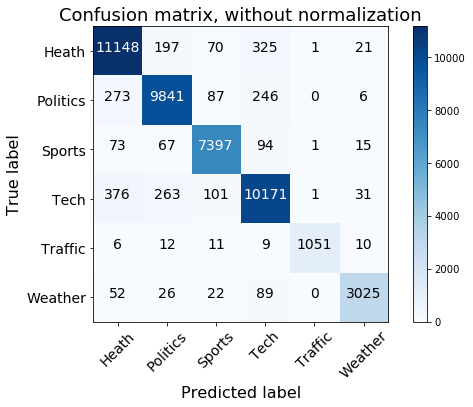

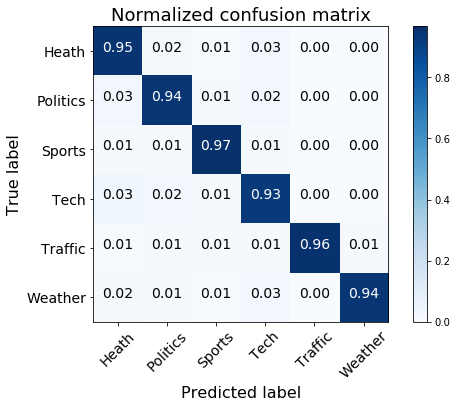

In [67]:
import itertools

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = target_names

# Plot non-normalized confusion matrix
plt.figure(figsize=(7.5, 5.5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


# Plot normalized confusion matrix
plt.figure(figsize=(7.5, 5.5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


## Learning Curves

To get more insight into the performance of the classifier and explore ways to improve its performance it is helpful to plot the learning curves. We can use tools from sklearn library to plot these curves:

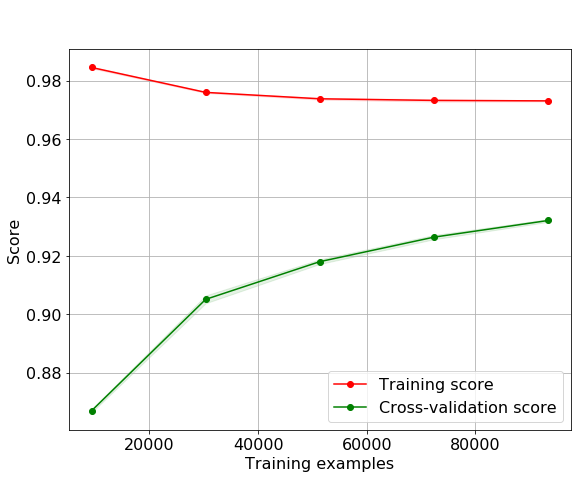

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), fontsize=20):

    plt.figure(figsize=(9, 7))
    plt.title(title, fontsize=19)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.yticks(fontsize=16)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right", fontsize=16)
    plt.grid(True)
    return train_sizes, train_scores, test_scores

estimator = LogisticRegression()
   
train_sizes, train_scores, test_scores = plot_learning_curve(
                                    estimator, title, tfidf_word_char, 
                                    tweets_df['cat_encoded'], n_jobs=4, cv=3)

plt.show();

The above figure shows the training and cross-validation score as a function of the number of training samples. The score here is the accuracy score, i.e., the fraction of samples that are classified correctly. The learning curves show that there is a large enough gap between the train and cv scores. In other words, the classifier suffer from some degree of over-fitting.

There are several ways to overcome over-fitting. Common ways to combat over-fitting are using regularization, reducing the number of features, and collecting more data. We have already tried regularization. Judging from the shape of the curve we may benefit substantially by collecting more data, since even for higher values of the sample size, the cross-validation score is increasing with substantial rate. Next, we try collecting more tweets to see how that affects our classifier's performance.

## Collecting More Tweets

We run the tweet collector for some more time to collect a total of 400000 tweets.

In [1]:
import pandas as pd

In [2]:
tweets_df = pd.read_pickle('data/tweets_df_total.pkl')


In [3]:
tweets_df = tweets_df[:400000]

In [4]:
tweets_df.shape

(400000, 6)

The number of tweets for each category:

In [10]:
tweets_df.cat.value_counts()

Sports      222250
Tech        192122
Politics    175150
Heath        93391
Traffic      46053
Weather      29469
Name: cat, dtype: int64

In [5]:
import scipy.sparse
#scipy.sparse.save_npz('data/tfidf_word_char.npz', tfidf_word_char)
tfidf_word_char = scipy.sparse.load_npz('data/tfidf_word_char.npz')

In [7]:
tfidf_word_char

<400000x1390978 sparse matrix of type '<type 'numpy.float64'>'
	with 167005138 stored elements in Compressed Sparse Row format>

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)

cv_index, test_index = sss.split(tfidf_word_char, tweets_df['cat_encoded']).next()

X_cv, y_cv = tfidf_word_char[cv_index], tweets_df['cat_encoded'][cv_index]
X_test, y_test = tfidf_word_char[test_index], tweets_df['cat_encoded'][test_index]


In [11]:
from sklearn.linear_model import LogisticRegression

In [11]:
clf = LogisticRegression(C=100)
clf.fit(X_cv, y_cv)
y_pred = clf.predict(X_test)

In [28]:
target_names = tweets_df[['cat_encoded', 'cat']].drop_duplicates().sort_values(['cat_encoded'])['cat'].tolist()

Similar to the previous sections, we obtain the performance measures for the new classifier:

In [29]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

      Heath       0.97      0.97      0.97     16236
   Politics       0.99      0.99      0.99     30528
     Sports       0.99      0.99      0.99     38585
       Tech       0.98      0.99      0.98     33442
    Traffic       1.00      1.00      1.00      8062
    Weather       0.99      0.97      0.98      5147

avg / total       0.99      0.99      0.99    132000



In [30]:
overall_accuracy = float(np.sum(y_test == y_pred))/y_test.shape[0]
overall_accuracy

0.9865530303030303

The classifier performance has greatly improved is all performance measures are around 99%!

Let's also plot the confusion matrices as before. They also show that performance has improved in all categories.

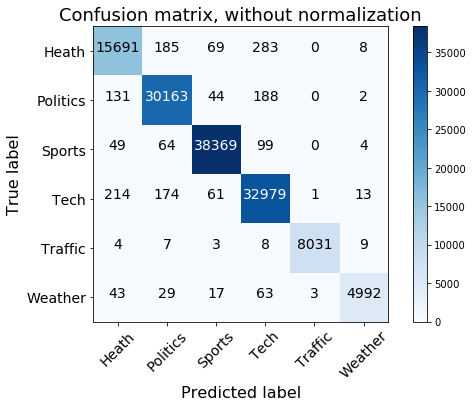

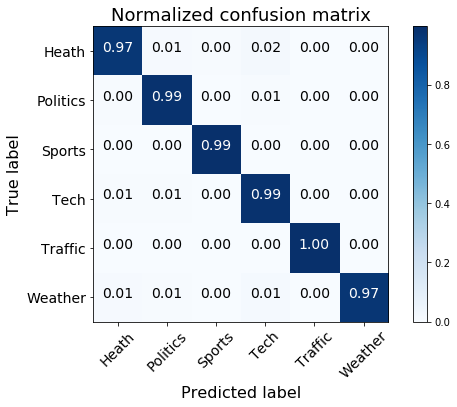

In [36]:
import itertools

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = target_names

# Plot non-normalized confusion matrix
plt.figure(figsize=(7.5, 5.5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


# Plot normalized confusion matrix
plt.figure(figsize=(7.5, 5.5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show();


In [13]:
from sklearn.linear_model import LogisticRegression

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), fontsize=20):

    plt.figure(figsize=(9, 7))
    plt.title(title, fontsize=19)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.yticks(fontsize=16)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right", fontsize=16)
    plt.grid(True)
    return train_sizes, train_scores, test_scores


In [11]:
from sklearn.linear_model import  LogisticRegression

In [ ]:
title = "Learning Curves"
estimator = LogisticRegression(C=100)
   
train_sizes, train_scores, test_scores = plot_learning_curve(
                                    estimator, title, tfidf_word_char, 
                                    tweets_df['cat_encoded'], n_jobs=1, cv=3)

plt.show();

## Weather Talks

To see our classifier in action, next we use it to detect when people are talking about the weather. In particular, we use the *Twitter streaming API* to access tweets that are sent by users in real time. We then use our classifier to filter out tweets that are classified to be Weather category.

In [ ]:
from pymongo import MongoClient
import json
from tweepy import Stream
from tweepy.streaming import StreamListener
import numpy as np
text_global = ""
class TweetListener(StreamListener):
 
    def on_data(self, data):
        global cnt, text_global
        try:
            tweet = json.loads(data)
            tweet_list.append(tweet)
            
            if 'extended_tweet' in tweet:
                text = tweet['extended_tweet']['full_text']
            else:
                text = tweet['text']
                
            text_processed = prep.fit_transform([text])
            if len(text_processed[0].split()) < 2:
                return True
            
            tfidf_word = tfidf_word_vectorizer.transform(text_processed)
            tfidf_char = tfidf_char_vectorizer.transform(text_processed)

            tfidf_word_char = hstack([tfidf_word, tfidf_char])

            y_pred = lr.predict(tfidf_word_char)
            y_pred_proba = lr.predict_proba(tfidf_word_char)
            
            if y_pred_proba[0][1] < 0.9:
                return True
            
            coordinates = None
            try:
                coordinates = tweet['place']['bounding_box'][u'coordinates']
            except KeyError:
                return True
                
            text_global = text
            tweet_output = ("Text: %s\nUser: %s\nProbability: %s\nCoordinates: %s\n"
                  % (text.encode('utf-8'), tweet['user']['screen_name'].encode('utf-8'), 
                     y_pred_proba[0][1], str(coordinates[0]))
            )
            print("--------------------------------------")
            print(tweet_output)
            
            coordinates_mean = np.array(coordinates[0]).mean(axis=0).tolist()
            f.write("%s, %s\n" % tuple(coordinates_mean))
            f.flush()
            
            cnt += 1
            if cnt % 1000 == 0:
                print(cnt)
            if cnt == max_count:
                twitter_stream.disconnect()
                print("done!")

        except BaseException as e:
            print("Error on_data: %s" % str(e))
            twitter_stream.disconnect()
            pass
        
        return True
    
    def on_error(self, status):
        print(status)
        return True



To achieve an even better classification performance, we can train a one-vs-all classifier. In other words, we transform the target variable by mapping the Weather category to value one, and all other categories to value zero. The result is a binary classifier that can detect tweets that specifically belong to Weather category. 

In [16]:
weather_df = (tweets_df['cat'] == 'Weather').astype(int)

lr = LogisticRegression(C=100)
lr.fit(tfidf_word_char, weather_df)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Next we run the Twitter streaming API to collect 20 tweets for which the probability of belonging to the Weather category is higher than 90%. The streaming API accepts a location parameter which can be use to filter out tweets that originate from a certain geographical area. Using this parameter we instruct the API to only collect tweets from US and Canada.

In [15]:
f = open("data/weather_tweets_coordinates", "a")
cnt = 0
tweet_list = []
max_count = 30
twitter_stream = Stream(auth=auth, listener=TweetListener())
GEOBOX_US_CANADA = [-128.755117, 26.415893, -52.437305, 54.093165]
twitter_stream.filter(locations=GEOBOX_US_CANADA)
f.close()


--------------------------------------
Text: @d_floyd28 Severe thunderstorm and expect heavy rain .
User: Derriika_
Probability: 0.9958669627518109
Coordinates: [[-81.666836, 28.072873], [-81.666836, 28.143168], [-81.584261, 28.143168], [-81.584261, 28.072873]]

--------------------------------------
Text: A ground stop is in place at #CLT due to WEATHER / THUNDERSTORMS #flightdelay https://t.co/OjiodwYGRT
User: lentaminen
Probability: 0.995599673067288
Coordinates: [[-81.046876, 35.001706], [-81.046876, 35.416412], [-80.646695, 35.416412], [-80.646695, 35.001706]]

--------------------------------------
Text: @JeremyRatliff @StormCenter7 We need the rain a little further north, please???
User: karensuegay
Probability: 0.9948831705033602
Coordinates: [[-84.307688, 39.695193], [-84.307688, 39.865523], [-84.093044, 39.865523], [-84.093044, 39.695193]]

--------------------------------------
Text: @MCO @VirginAtlantic Big and magic under the rain https://t.co/009TAPmD54
User: MaxiDonadio

As we can see, the classifier has done a great job in detecting the Weather related tweets. Occasionally we see a tweet that is mis-classified, for example the tweet "Jon Snow a real one." is not about the Weather. We can reduce the possibility of such tweets by filtering out short tweets, e.g.,  tweets with fewer than 10 words. In addition, some of the detected tweets seem to be from weather agencies and therefore not posted by read people. We can also remove these tweets by preparing a list of business Twitter account that are not owned by individuals and removing the related tweets.

In the above, in addition to tweet text, we collected the coordinates information of the tweets. We can use this information to create a heat-map visualization of the weather tweets. We use google-maps and gmaps library for this purpose. Similar to Twitter, we need to register an app with google-maps to be able to access the map data. Once we register, we receive an API key which we can use together with gmaps to create heatmap visualization.

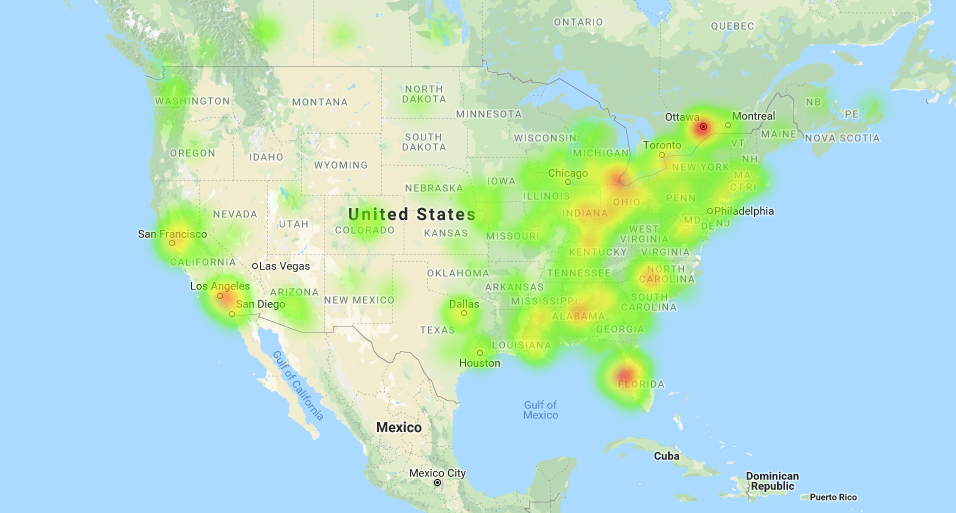

In [12]:
import gmaps
import gmaps.datasets

f = open("data/weather_tweets_coordinates")
locations = []
for l in f.readlines():
    longitude, latitude = map(float, l.split(','))
    locations.append((latitude, longitude))
f.close()

gmaps.configure(api_key=<google map api-key>)

fig = gmaps.figure()
heatmap = gmaps.heatmap_layer(locations)
heatmap.point_radius = 20
fig.add_layer(heatmap)

Today, there is a heat-wave going on in the afternoon, as was the case on many days during this summer (summer 2018). This could explain why we see a higher number of tweets posted in Florida and California. Also right now there is an thunder storm happening in Ottawa which explains high concentration of tweets around this city.